In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
from rdkit import Chem
from rdkit.Chem import Descriptors
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.metrics import mean_squared_error

In [2]:
import glob
import pickle

# Load all history files
history_files = sorted(glob.glob('SE+CN_MODEL/history_epoch_*.pkl'))

val_losses = []

for file in history_files:
    with open(file, 'rb') as f:
        epoch_history = pickle.load(f)
    val_losses.append(epoch_history['val_loss'][-1])  # Assuming last value per epoch is relevant

# Find best epoch
best_epoch = int(history_files[val_losses.index(min(val_losses))].split('_')[-1].split('.')[0])
best_val_loss = min(val_losses)

print(f"✅ Best Epoch: {best_epoch}")
print(f"📉 Best Validation Loss: {best_val_loss:.6f}")


✅ Best Epoch: 92
📉 Best Validation Loss: 0.691010


In [3]:
model = tf.keras.models.load_model(f'SE+CN_MODEL/model_epoch_{best_epoch}.h5')
model.summary()  # optional

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ smiles_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 64)   │      2,688 │ smiles_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1000, 64)  │      1,344 │ protein_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 100, 128)  │     41,088 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1000, 128) │     73,856 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 100, 128)  │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1000, 128) │    147,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mol_desc_input      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prot_desc_input     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_9[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_11[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │        192 │ mol_desc_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │        160 │ prot_desc_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 466,467 (1.78 MB)

 Trainable params: 465,313 (1.78 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 2 (12.00 B)

In [4]:
df = pd.read_csv('test_dataset.csv')

In [5]:
# --- Molecular descriptors from SMILES ---
def compute_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * 5
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol)
    ]

df[['MolWt', 'LogP', 'RotatableBonds', 'HDonors', 'HAcceptors']] = df['SMILES'].apply(
    compute_molecular_descriptors
).apply(pd.Series)

# --- Protein descriptors from sequence ---
def compute_protein_descriptors(seq):
    try:
        analyzed_seq = ProteinAnalysis(seq)
        return [
            analyzed_seq.molecular_weight(),
            analyzed_seq.aromaticity(),
            analyzed_seq.instability_index(),
            analyzed_seq.gravy()
        ]
    except:
        return [None] * 4
    
df[['Prot_MW', 'Aromaticity', 'Instability', 'Hydropathy']] = df['target_sequence'].apply(
    compute_protein_descriptors
).apply(pd.Series)

In [6]:
df = df.dropna(subset=[
    'MolWt', 'LogP', 'RotatableBonds', 'HDonors', 'HAcceptors',
    'Prot_MW', 'Aromaticity', 'Instability', 'Hydropathy'
])


In [7]:
x_descriptor = df[['MolWt', 'LogP', 'RotatableBonds', 'HDonors', 'HAcceptors']].values
X_protein_descriptor = df[['Prot_MW', 'Aromaticity', 'Instability', 'Hydropathy']].values


In [8]:
# Encode SMILES
smiles_chars = sorted(set(''.join(df['SMILES'])))
char_to_int_smiles = {c: i + 1 for i, c in enumerate(smiles_chars)}

def encode_smiles(smiles):
    return [char_to_int_smiles.get(c, 0) for c in smiles]

df['smiles_encoded'] = df['SMILES'].apply(encode_smiles)

# Encode protein sequence
aa_list = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i + 1 for i, aa in enumerate(aa_list)}

def encode_protein(seq):
    return [aa_to_int.get(aa, 0) for aa in seq]

df['protein_encoded'] = df['target_sequence'].apply(encode_protein)

# Pad
max_len_smiles = 100
max_len_protein = 1000

X_smiles_test = pad_sequences(df['smiles_encoded'], maxlen=max_len_smiles, padding='post')
X_protein_test = pad_sequences(df['protein_encoded'], maxlen=max_len_protein, padding='post')
y_test = df['Kd'].values

In [9]:
# Predict
y_pred = model.predict([X_smiles_test, X_protein_test, x_descriptor, X_protein_descriptor]).flatten()

191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error , root_mean_squared_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 0.7225
Mean Absolute Error: 0.5410
Root Mean Squared Error: 0.8500


C:\Users\NongNam\AppData\Local\Temp\ipykernel_18292\1715855994.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="True Kd", shade=True)
C:\Users\NongNam\AppData\Local\Temp\ipykernel_18292\1715855994.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label="Predicted Kd", shade=True)


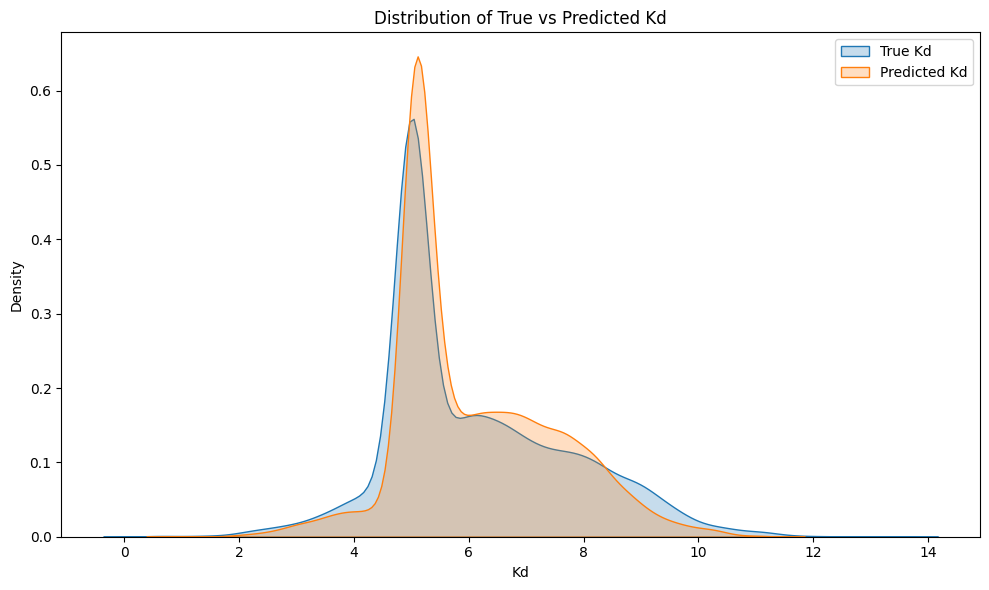

In [11]:
# Plot real vs predicted distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label="True Kd", shade=True)
sns.kdeplot(y_pred, label="Predicted Kd", shade=True)
plt.title("Distribution of True vs Predicted Kd")
plt.xlabel("Kd")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

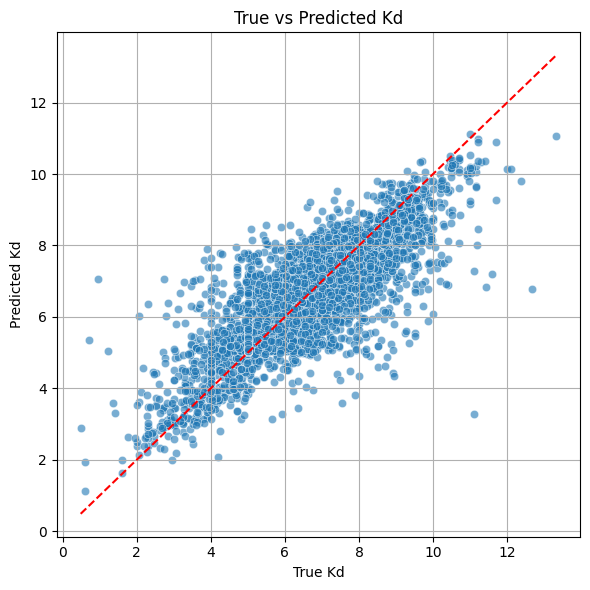

In [12]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # y = x line
plt.xlabel("True Kd")
plt.ylabel("Predicted Kd")
plt.title("True vs Predicted Kd")
plt.grid(True)
plt.tight_layout()
plt.show()


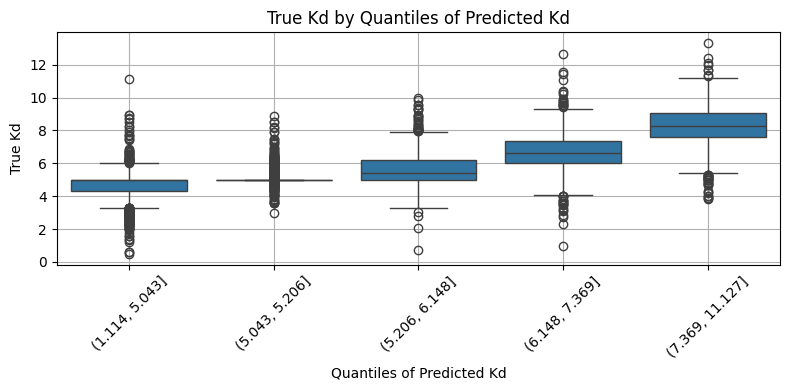

In [13]:
quantiles = pd.qcut(y_pred, q=5, duplicates='drop')  # 5 quantiles (change if needed)
plt.figure(figsize=(8, 4))
sns.boxplot(x=quantiles, y=y_test)
plt.xticks(rotation=45)
plt.xlabel("Quantiles of Predicted Kd")
plt.ylabel("True Kd")
plt.title("True Kd by Quantiles of Predicted Kd")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
mse = mean_squared_error(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")

Test MSE: 0.7225
